In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras

Exercise 8f.

In [2]:
(x_train_full, y_train_full), (x_test, y_test) = keras.datasets.cifar10.load_data()

def split_train_valid(data, split_number=5000):
    return data[split_number:], data[:split_number]

x_train, x_valid = split_train_valid(x_train_full)
y_train, y_valid = split_train_valid(y_train_full)

x_means = x_train.mean(axis=0)
x_stds = x_train.std(axis=0)
x_train_scaled = (x_train - x_means) / x_stds
x_valid_scaled = (x_valid - x_means) / x_stds
x_test_scaled = (x_test - x_means) / x_stds

In [3]:
import math

K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs['loss'])
        K.set_value(self.model.optimizer.lr, 
                    self.model.optimizer.lr * self.factor)


def find_learning_rate(model, x, y, epochs=1, batch_size=32, 
                       min_rate=10 ** -5, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(len(x) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(x, y, epochs=epochs, 
                        batch_size=batch_size, 
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses


def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel('Learning rate', fontsize=14)
    plt.ylabel('Loss', fontsize=14)

In [4]:
 class OneCycleScheduler(keras.callbacks.Callback):
        def __init__(self, iterations, max_rate, start_rate=None, 
                     last_iterations=None, last_rate=None):
            self.iterations = iterations
            self.max_rate = max_rate
            self.start_rate = start_rate or max_rate / 10
            self.last_iterations = last_iterations or iterations // 10 + 1
            self.half_iteration = (iterations - self.last_iterations) // 2
            self.last_rate = last_rate or self.start_rate / 1000
            self.iteration = 0
            
        def _interpolate(self, iter1, iter2, rate1, rate2):
            return ((rate2 - rate1) * (self.iteration - iter1) 
                    / (iter2 - iter1) + rate1)
        
        def on_batch_begin(self, batch, logs):
            if self.iteration < self.half_iteration:
                rate = self._interpolate(0, self.half_iteration, 
                                         self.start_rate, self.max_rate)
            elif self.iteration < 2 * self.half_iteration:
                rate = self._interpolate(self.half_iteration, 2 * self.half_iteration, 
                                         self.max_rate, self.start_rate)
            else:
                rate = self._interpolate(2 * self.half_iteration, self.iterations, 
                                         self.start_rate, self.last_rate)
            self.iteration += 1
            K.set_value(self.model.optimizer.lr, rate)

In [5]:
def make_model():
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
    for i in range(20):
        model.add(keras.layers.Dense(100, 
                                     activation='selu', 
                                     kernel_initializer='lecun_normal'))
    model.add(keras.layers.AlphaDropout(rate=0.1))
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

In [6]:
loss = 'sparse_categorical_crossentropy'
optimizer = keras.optimizers.SGD(learning_rate=1e-4)

352/352 [==============================] - 3s 6ms/step - loss: nan - acc: 0.1472


(9.999999747378752e-06,
 9.615227699279785,
 2.593752861022949,
 3.9678849492754256)

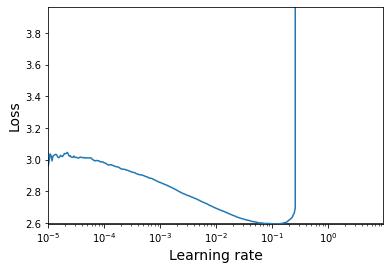

In [7]:
model = make_model()

model.compile(loss=loss, optimizer=optimizer, metrics=['acc'])

batch_size = 128
rates, losses = find_learning_rate(model, x_train_scaled, y_train, 
                                   epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)
plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 1.4])

In [8]:
n_epochs = 15

model = make_model()
optimizer = keras.optimizers.SGD(learning_rate=1e-2)
model.compile(loss=loss, optimizer=optimizer, metrics=['acc'])

onecycle = OneCycleScheduler(len(x_train_scaled) // batch_size * n_epochs, max_rate=0.05)

history = model.fit(x_train_scaled, y_train, 
                    epochs=n_epochs, batch_size=batch_size,
                    validation_data=(x_valid_scaled, y_valid), 
                    callbacks=[onecycle])

Epoch 1/15
352/352 [==============================] - 3s 7ms/step - loss: 2.0680 - acc: 0.2797 - val_loss: 1.7697 - val_acc: 0.3808
Epoch 2/15
352/352 [==============================] - 2s 7ms/step - loss: 1.7624 - acc: 0.3752 - val_loss: 1.6964 - val_acc: 0.4010
Epoch 3/15
352/352 [==============================] - 2s 7ms/step - loss: 1.6205 - acc: 0.4249 - val_loss: 1.6155 - val_acc: 0.4268
Epoch 4/15
352/352 [==============================] - 2s 7ms/step - loss: 1.5430 - acc: 0.4518 - val_loss: 1.6587 - val_acc: 0.4276
Epoch 5/15
352/352 [==============================] - 3s 7ms/step - loss: 1.4885 - acc: 0.4718 - val_loss: 1.5922 - val_acc: 0.4410
Epoch 6/15
352/352 [==============================] - 3s 7ms/step - loss: 1.4527 - acc: 0.4874 - val_loss: 1.5899 - val_acc: 0.4472
Epoch 7/15
352/352 [==============================] - 2s 7ms/step - loss: 1.4135 - acc: 0.5005 - val_loss: 1.5352 - val_acc: 0.4802
Epoch 8/15
352/352 [==============================] - 2s 7ms/step - loss: 1.

In [9]:
model.evaluate(x_valid_scaled, y_valid)

157/157 [==============================] - 0s 1ms/step - loss: 1.5881 - acc: 0.5256


[1.5881247520446777, 0.525600016117096]

In [10]:
model.evaluate(x_test_scaled, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 1.5982 - acc: 0.5174


[1.598231554031372, 0.5174000263214111]